CIFAR-10 datasets are 32 by 32 images of 10 different objects
- airplanes
- car
- bird
- cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

These are colored images (have three channels)

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [91]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
train_data = datasets.CIFAR10(root="../Data", train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [69]:
test_data = datasets.CIFAR10(root="../Data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [70]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [71]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [72]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data,batch_size=100, shuffle=False)

In [73]:
train_data[0][0].shape

torch.Size([3, 32, 32])

In [74]:
class_names = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

In [75]:
for images,labels in train_loader:
    break

In [76]:
labels

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8, 7, 0, 9, 4, 1, 7, 9, 4, 0, 6, 4, 2, 9, 5,
        5, 0, 9, 7, 0, 2, 8, 4, 6, 6, 7, 4, 4, 3, 6, 8, 9, 2, 9, 3, 0, 1, 4, 5,
        6, 8, 2, 5, 0, 2, 1, 1, 8, 0, 0, 2, 2, 8, 3, 2, 1, 9, 9, 2, 0, 5, 9, 3,
        5, 4, 5, 6, 8, 3, 3, 9, 3, 3, 4, 2, 9, 8, 7, 8, 2, 8, 9, 5, 0, 3, 0, 6,
        2, 5, 5, 3])

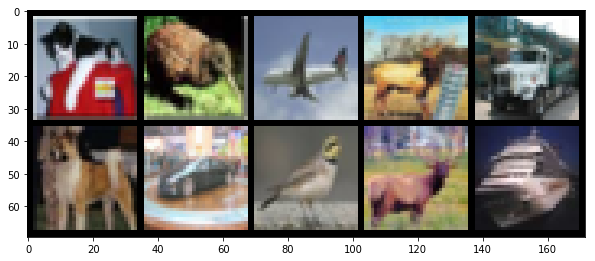

In [77]:
im = make_grid(images[:10],nrow=5)
plt.figure(figsize=(10,20))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [78]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,12,4,1) # (input channel, output_channel, kernel size)
        self.conv2 = nn.Conv2d(12,28,3,1) 
        self.fc1 = nn.Linear(6*6*28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,6*6*28)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim=1)
        return X

In [79]:
torch.manual_seed(101)
model = ConvolutionalNetwork()

In [80]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [81]:
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [83]:
import time
start_time = time.time()

# Variables(Trackes)
epochs = 20
train_losses = []
test_losses = []
train_corrects = []
test_corrects = []

# Epochs
for epoch in range(epochs):
    train_corr = 0
    test_corr = 0

    # TRAIN
    for batch, (X_train, y_train) in enumerate(train_loader):
        batch = batch+1
        if CUDA:
            X_train = X_train.cuda()
            y_train = y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        train_corr += (y_pred.argmax(axis=1) == y_train).sum()
        correct_guess = (y_pred.argmax(axis=1) == y_train).sum().float() / y_train.shape[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}]. Batch : {batch}. Loss : {loss.item()}. Correct : {correct_guess * 100:.2f} %')
        
    train_losses.append(loss)
    train_corrects.append(train_corr)
    
    # TEST
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            if CUDA:
                X_test = X_test.cuda()
                y_test = y_test.cuda()
            y_val = model(X_test)
            test_corr += (y_val.argmax(axis=1) == y_test).sum()
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_corrects.append(test_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training took {total/60} minutes')

Epoch [0/20]. Batch : 100. Loss : 1.9905117750167847. Correct : 31.00 %
Epoch [0/20]. Batch : 200. Loss : 1.793544054031372. Correct : 29.00 %
Epoch [0/20]. Batch : 300. Loss : 1.6235156059265137. Correct : 47.00 %
Epoch [0/20]. Batch : 400. Loss : 1.4773030281066895. Correct : 47.00 %
Epoch [0/20]. Batch : 500. Loss : 1.7924326658248901. Correct : 32.00 %
Epoch [1/20]. Batch : 100. Loss : 1.602596640586853. Correct : 44.00 %
Epoch [1/20]. Batch : 200. Loss : 1.4238322973251343. Correct : 44.00 %
Epoch [1/20]. Batch : 300. Loss : 1.2802000045776367. Correct : 57.00 %
Epoch [1/20]. Batch : 400. Loss : 1.2872616052627563. Correct : 57.00 %
Epoch [1/20]. Batch : 500. Loss : 1.2377902269363403. Correct : 61.00 %
Epoch [2/20]. Batch : 100. Loss : 1.1950924396514893. Correct : 62.00 %
Epoch [2/20]. Batch : 200. Loss : 1.2190405130386353. Correct : 58.00 %
Epoch [2/20]. Batch : 300. Loss : 1.3392913341522217. Correct : 59.00 %
Epoch [2/20]. Batch : 400. Loss : 1.1554639339447021. Correct : 57

In [84]:
# It is very important that we save the model parameters after we finish the test
torch.save(model.state_dict(),'MyCIFAR10Model.pt')

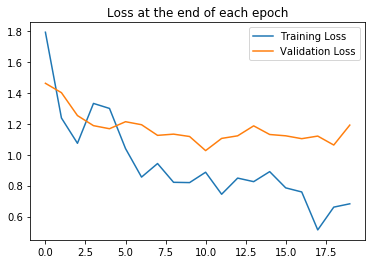

In [85]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses,label="Validation Loss")
plt.title("Loss at the end of each epoch")
plt.legend()

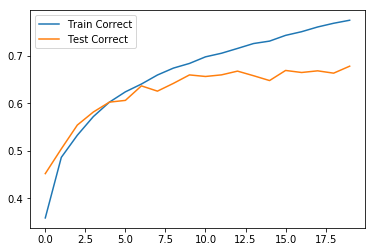

In [86]:
plt.plot([t.float()/50000 for t in train_corrects], label="Train Correct")
plt.plot([t.float()/10000 for t in test_corrects], label="Test Correct")
plt.legend()

In [89]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        if CUDA:
            X_test = X_test.cuda()
            y_test = y_test.cuda()
        pred = model(X_test)
        correct += (pred.argmax(axis=1) == y_test).sum()

In [95]:
arr = confusion_matrix(y_test.cpu().view(-1), pred.argmax(1).view(-1).cpu())

Text(60.0, 0.5, 'label (Ground Truth)')

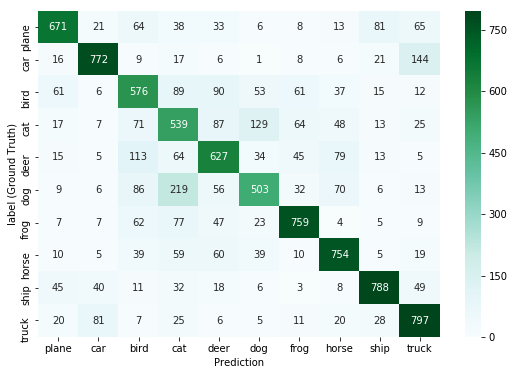

In [96]:
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize=(9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="BuGn")
plt.xlabel('Prediction')
plt.ylabel('label (Ground Truth)')